In [185]:
import sys

import matplotlib.pyplot as plt

import cv2
from drosoph3D.GUI.os_util import *
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import Axes3D
from drosoph3D.GUI.CameraNetwork import CameraNetwork
import drosoph3D.GUI.skeleton as skeleton
import pickle
import glob
from drosoph3D.GUI.plot_util import *
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')


from matplotlib.ticker import FuncFormatter, MultipleLocator
def draw_time_series(ax, pts3d, segmentation=None, colors_time=None, colors=None, tick=None, ylim=None, fps=100, bias=-140, show_activation=False):
    if fps is not None:
        fps = float(fps)
    if segmentation is not None: 
        n_clusters = len(list(set(segmentation)))
    if colors is None and segmentation is not None:
        cm = plt.get_cmap('gist_rainbow')
        colors = [cm(1.*i/n_clusters) for i in range(n_clusters)]

    for j_idx in range(pts3d.shape[1]):
        if colors_time is None:
            ax.plot(np.arange((0+bias)/fps,(pts3d.shape[0]+bias)/fps, 1/fps), pts3d[j_idx,:])
        else:
            ax.plot(np.arange((0+bias)/fps,(pts3d.shape[0]+bias)/fps, 1/fps), pts3d[:,j_idx], color=colors_time[j_idx])
    if ylim is None:
        ylim = [0, 3.14]
    
    if show_activation:
        ax.axvspan(0, 5, facecolor='red', alpha=0.1)
    
    if segmentation is not None:
        segmentation_boundaries_list = []
        h = None
        boundary_idx = 0
        segmentation_boundaries_list.append([0,None,segmentation[0]])
        for idx, clstr in enumerate(segmentation):
            if clstr!=h:
                h=clstr
                segmentation_boundaries_list[boundary_idx][1]=idx
                segmentation_boundaries_list.append([idx, None, clstr])
                boundary_idx +=1
        segmentation_boundaries_list[-1][1]=pts3d.shape[0]
        segmentation_boundaries_list = np.array(segmentation_boundaries_list)

        for start, end, clstr in segmentation_boundaries_list:
            ax.axvspan((start+bias)/fps, (end+bias)/fps, facecolor=colors[clstr], alpha=0.2)
            
            
    if tick is not None:
        if type(tick)!=list:
            tick = [tick]
        for t in tick:
            ax.axvline(x=(t+bias)/fps, color='white', linestyle='--')
    
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(FuncFormatter(
       lambda val,pos: '$\pi$'.format(val/np.pi) if val !=0 else '0'
    ))
    ax.yaxis.set_major_locator(MultipleLocator(base=np.pi))
    ax.set_xlabel('seconds')
    
    ax.set_xticks([-1.4, 0, 1, 2, 3, 4, 5, 6, 7.6])

def angle_three_points(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading the Data

In [179]:
import matplotlib.gridspec as gridspec
from drosoph3D.GUI.Camera import Camera
from OneEuroFilter import filter_batch, filter_batch_2d
%matplotlib inline
plt.style.use('dark_background')

c = cam_id = 1
image_folder = '/data/paper/180920_MDN_CsCh/Fly9/001_SG1/behData/images'
#image_folder = '/data/paper/180921_aDN_CsCh/Fly6/001_SG1/behData/images/'
#image_folder = '/data/paper/180918_MDN_PR/Fly1/003_SG1/behData/images/'

img_id_list = range(1)
cam_id = 1
d = np.load(glob.glob(os.path.join(image_folder, 'pose_result*.pkl'))[0])
points2d = d["points2d"][cam_id]
pts3d = d["points3d"]
cam = Camera(image_folder=image_folder, cid=cam_id, points2d=points2d)

# smooth points2d on Camera
print(np.sum(cam.points2d-filter_batch_2d(cam.points2d)))
cam.points2d = filter_batch_2d(cam.points2d)

# prepare 3d plot data
pts_t = pts3d.copy()
pts_t = filter_batch(pts3d)
tmp = pts_t[:,:,1].copy()
pts_t[:,:,1] = pts_t[:,:,2].copy()
pts_t[:,:,2] = tmp
pts_t[:,:,2] *=-1 
pts_t[:,:,1] *=-1 
pts_t = normalize_pose_3d(pts_t, normalize_median=True)


# prepare the angle data
data = pts3d.copy()
data_angle = np.zeros((data.shape[0], data.shape[1]), dtype=np.float32)
for img_id in range(data.shape[0]):
    for j_id in range(1, data.shape[1]-1):
        if skeleton.is_tarsus_tip(j_id) or skeleton.is_stripe(j_id) or skeleton.is_antenna(j_id):
            continue
        data_angle[img_id, j_id] = angle_three_points(
            pts_t[img_id, j_id - 1, :],
            pts_t[img_id, j_id, :],
            pts_t[img_id, j_id + 1, :])
        data_angle[img_id, j_id] = angle_three_points(
            pts_t[img_id, j_id - 1, :],
            pts_t[img_id, j_id, :],
            pts_t[img_id, j_id + 1, :])
        data_angle[img_id, j_id] = angle_three_points(
            pts_t[img_id, j_id - 1, :],
            pts_t[img_id, j_id, :],
            pts_t[img_id, j_id + 1, :])
data_angle[np.logical_or(np.isnan(data_angle), np.isinf(data_angle))] = 0

zorder = skeleton.get_zorder(cam_id)

thickness = [5]*skeleton.num_limbs

colors_tmp = None
for l in range(skeleton.num_limbs):
    if not skeleton.camera_see_limb(cam_id, l):
        thickness[l] = 2
        #colors_tmp[l] = (0,0,0)
    else:
        #colors_tmp[l] = (255,0,0)
        thickness[l] = 2

for j in range(skeleton.num_joints):
    if skeleton.is_stripe(j):
        #colors_tmp[skeleton.get_limb_id(j)] = (0,255,255)
        thickness[l]=2

3511.8863522336965


0
50
100
150
200
250
300
350
400
450


KeyboardInterrupt: 

<Figure size 3888x1800 with 0 Axes>

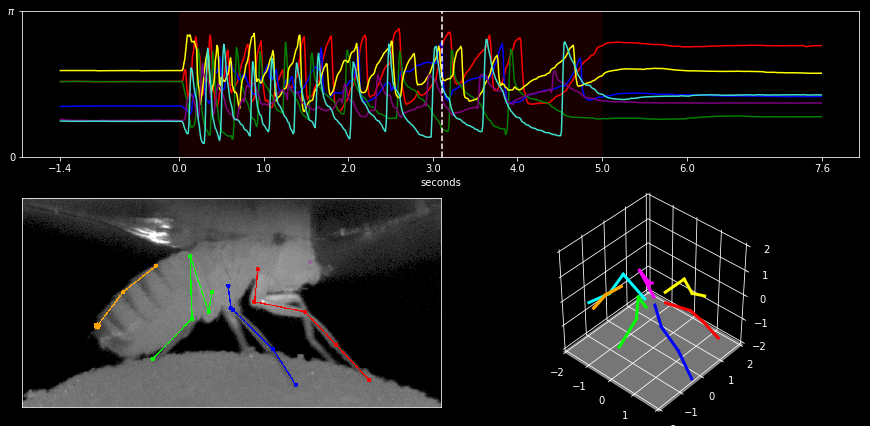

In [188]:
num_rows, num_cols = 5, 6
joints_to_draw = [2,7,12, skeleton.num_joints//2+2, skeleton.num_joints//2+2+5, skeleton.num_joints//2+2+10]
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'turquoise']
fig = plt.figure(figsize=(num_cols*9,num_rows*5))

gs1 = gridspec.GridSpec(num_rows, num_cols)
gs1.update(wspace=0, hspace=0.5) # set the spacing between axes. 

plt.figure(figsize=(15,7.5))

ax1 = plt.subplot(gs1[:2,:])
ax2 = plt.subplot(gs1[2:,:3])
ax3 = plt.subplot(gs1[2:,3:], projection='3d')

ax2_set_data = ax2.imshow(cam.plot_2d(img_id=0))
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_title(image_folder)
img_id_list = range(0, 900)

for img_id in img_id_list:
    if img_id%50==0:
        print(img_id)
    #img_id = 162
    ax1.clear()
    draw_time_series(ax1, np.squeeze(data_angle[:,[joints_to_draw]]), tick=img_id, segmentation=None, show_activation=True, colors_time=colors)
    ax2_set_data.set_data(cam.plot_2d(img_id=img_id, zorder=zorder))
    
    c = cam_id = 1
    points3d = pts_t[img_id,:,:]
    ang = -90 - (camNet[c].rvec[1]*57.2)
    period = 180 # frames
    extend = 20
    ang_move = np.sin(2*np.pi*((img_id)/period))*extend
    ang += ang_move
    
    ax3.elev = 40
    draw_joints = [j for j in range(skeleton.num_joints) if (skeleton.is_coxa_femur(j) or skeleton.is_femur_tibia(j) or skeleton.is_tibia_tarsus(j) or skeleton.is_tarsus_tip(j) or skeleton.is_stripe(j))]
    zorder = skeleton.get_zorder(c)
    plot_drosophila_3d(ax_3d=ax3, points3d=pts_t[img_id,:], cam_id=c, ang=ang, draw_joints=draw_joints, zorder=zorder, colors=colors_tmp)
    plt.savefig('/home/user/Desktop/tmp/mdn_time/{}.png'.format(img_id), figsize=(40,20), dpi=160)
    ax3.cla()
    
#os.system("ffmpeg -r 30 -i /home/user/Desktop/tmp/adn_time/%.png -pix_fmt yuv420p -vb 20M /home/user/Desktop/tmp/adn_time/movie.mp4")

In [35]:
os.system("ffmpeg -r 30 -i /home/user/Desktop/tmp/mdn_time/%d.png -pix_fmt yuv420p -vb 20M /home/user/Desktop/tmp/mdn_time/movie.mp4")

0

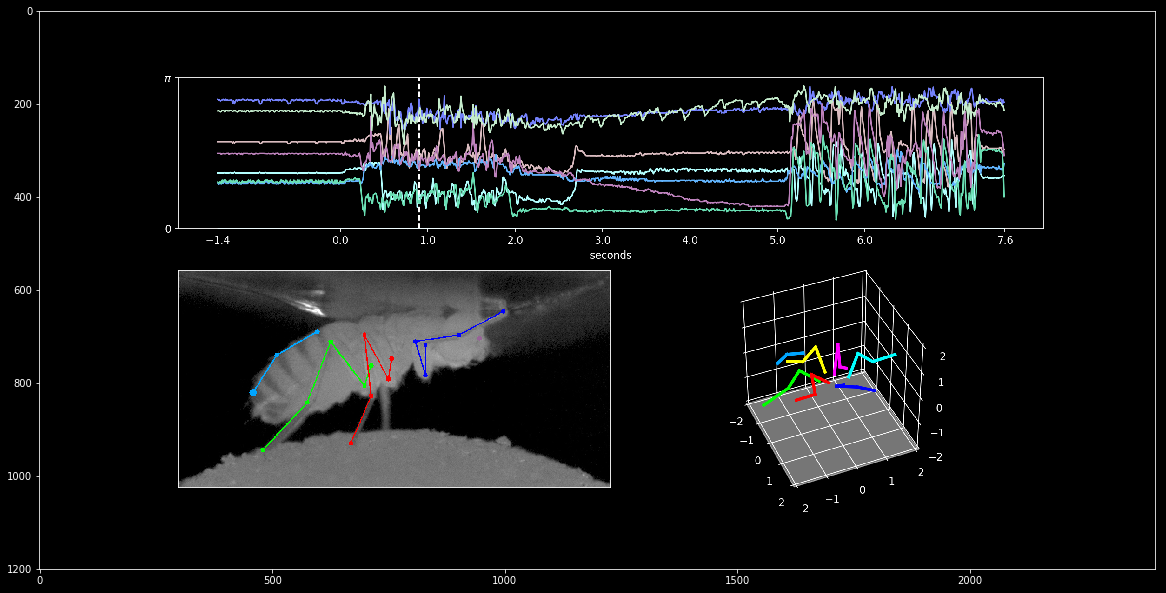

In [90]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.imread('/home/user/Desktop/tmp/adn_time/230.png'))